In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import librosa
from tqdm import tqdm
import pickle
import os

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from imblearn.over_sampling import RandomOverSampler, SMOTE

N_MFCC = 20

# Load Accent Data

In [2]:
# load accent data
accent_df = pd.read_csv('data/speakers_all.csv')
accent_df.head()

# drop extra cols
accent_df.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis='columns', inplace=True)

# drop files with missing recordings
accent_df = accent_df[accent_df['file_missing?'] == False]
accent_df.reset_index(inplace=True)

accent_df.describe(include='all')  # country is too sparse to predict on

# only use top 5 languages
top_languages = accent_df.value_counts('native_language').index[:5].tolist()
accent_df = accent_df[accent_df['native_language'].isin(top_languages)]

In [3]:
top_languages

['english', 'spanish', 'arabic', 'mandarin', 'french']

# Load and Clean Recordings

In [4]:
# load recordings
RECORDINGS_PATH = 'data/recordings'
recordings = []
for filename in tqdm(os.listdir(RECORDINGS_PATH)):
    # load recording
    wav, _ = librosa.load(RECORDINGS_PATH + '/' + filename, sr=16000)
    recordings.append([filename.split('.')[0], wav])
    
recordings = pd.DataFrame(recordings, columns=['filename', 'recording'])

100%|██████████| 2138/2138 [01:43<00:00, 20.74it/s]


In [5]:
# sync recordings filenames with accents_df filenames
accent_df = accent_df[accent_df['filename'].isin(recordings['filename'])]
recordings = recordings[recordings['filename'].isin(accent_df['filename'])]
recordings['filename'].tolist() == accent_df['filename'].tolist()

True

In [6]:
# adding recording length columns
recordings['length'] = [len(rec) for rec in recordings['recording']]
recordings['seconds'] = recordings['length'] / 16000
recordings.head()

,filename,recording,length,seconds
38,arabic1,"[0.0034055007, 0.00507906, 0.004128609, 0.0059...",727040,45.440000
39,arabic10,"[0.0044173095, 0.0073645804, 0.0061291405, 0.0...",594647,37.165438
40,arabic100,"[0.0008470416, -5.936902e-05, 5.0850602e-05, -...",480165,30.010313
41,arabic101,"[-7.440333e-05, -0.00016715181, 0.0014305564, ...",604365,37.772813
42,arabic102,"[3.7324644e-06, -2.8190887e-05, -2.388857e-05,...",311343,19.458938


count    971.000000
mean      26.110592
std        7.538356
min       16.460563
25%       21.214125
50%       23.723562
75%       28.629000
max       85.119187
Name: seconds, dtype: float64


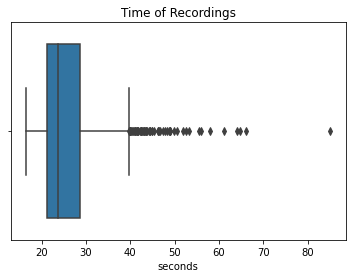

In [7]:
# some recordings are rediculously long
print(recordings['seconds'].describe())
sns.boxplot(data=recordings, x='seconds')
plt.title('Time of Recordings')
plt.show()

In [8]:
# truncate recordings to the minimum length
min_rec_length = recordings['length'].min()
recordings_std = [recording[:min_rec_length] for recording in recordings['recording']]

In [9]:
# convert to numpy
X = np.array(recordings_std)

# define y
y = accent_df['native_language']
n_classes = len(accent_df['native_language'].unique())
le = LabelEncoder()
le.fit(y)

LabelEncoder()

In [10]:
def preproc(X, y, n_mfcc):
# split data into train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify=y_train)

    # data augmentation
    X_train_aug = X_train + np.random.normal(0, 0.1, X_train.shape)
    np.append(X_train, X_train_aug)
    np.append(y_train, y_train)

    # apply smote to fix class imbalance
    resample = SMOTE()
    X_train, y_train = resample.fit_resample(X_train, y_train)
    
    # apply mfcc transformation
    X_train = np.array([librosa.feature.mfcc(y=x, sr=16000, n_mfcc=n_mfcc) for x in tqdm(X_train)])
    X_test = np.array([librosa.feature.mfcc(y=x, sr=16000, n_mfcc=n_mfcc) for x in tqdm(X_test)])
    X_val = np.array([librosa.feature.mfcc(y=x, sr=16000, n_mfcc=n_mfcc) for x in tqdm(X_val)])
    
    # reshape X
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    
    # encode y
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)
    y_train = to_categorical(y_train, num_classes=n_classes)
    y_val = to_categorical(y_val, num_classes=n_classes)
    y_test = to_categorical(y_test, num_classes=n_classes)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [11]:
X_train, X_test, X_val, y_train, y_test, y_val = preproc(X, y, N_MFCC)

100%|██████████| 156/156 [00:04<00:00, 35.40it/s]


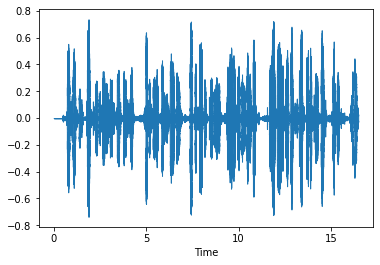

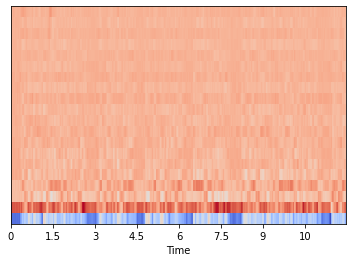

In [12]:
# display example waveform
librosa.display.waveshow(X[100], sr=16000)
plt.show()

# display example spectrogram
librosa.display.specshow(X_train[100].reshape(X_train.shape[1], X_train.shape[2]), x_axis='time')
plt.show()

# pickle

In [13]:
# save to pickle
import pickle
with open('data.pkl', 'wb') as f:
    pickle.dump([
        X_train, X_test, X_val,
        y_train, y_test, y_val,
        accent_df
    ], f)

In [14]:
# load data from pickle
import pickle
with open('data.pkl', 'rb') as f:
    X_train, X_test, X_val, y_train, y_test, y_val, accent_df = pickle.load(f)

# CNN

In [15]:
input_shape = X_train.shape[1:]
kernel_size = 3
n_classes = 5

# define network
model = Sequential()
model.add(Conv2D(16, kernel_size=kernel_size, padding='same', input_shape=input_shape))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(32, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(128, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 515, 16)       160       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20, 515, 16)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 257, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 257, 32)       4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 10, 257, 32)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 128, 32)       0         
 2D)                                                    

Epoch 1/100
58/58 [==============================] - 11s 160ms/step - loss: 7.7236 - accuracy: 0.1773 - val_loss: 1.8001 - val_accuracy: 0.2308
Epoch 2/100
58/58 [==============================] - 10s 177ms/step - loss: 3.0859 - accuracy: 0.1995 - val_loss: 1.4789 - val_accuracy: 0.3846
Epoch 3/100
58/58 [==============================] - 10s 180ms/step - loss: 2.1558 - accuracy: 0.2162 - val_loss: 1.7049 - val_accuracy: 0.1731
Epoch 4/100
58/58 [==============================] - 10s 172ms/step - loss: 2.0752 - accuracy: 0.2119 - val_loss: 1.5349 - val_accuracy: 0.3462
Epoch 5/100
58/58 [==============================] - 9s 161ms/step - loss: 1.9650 - accuracy: 0.2319 - val_loss: 1.6167 - val_accuracy: 0.2500
Epoch 6/100
58/58 [==============================] - 10s 165ms/step - loss: 1.9581 - accuracy: 0.2497 - val_loss: 1.5665 - val_accuracy: 0.2692
Epoch 7/100
58/58 [==============================] - 10s 166ms/step - loss: 1.8661 - accuracy: 0.2654 - val_loss: 1.6490 - val_accuracy: 

Epoch 58/100
58/58 [==============================] - 9s 161ms/step - loss: 0.9196 - accuracy: 0.6492 - val_loss: 1.3262 - val_accuracy: 0.5513
Epoch 59/100
58/58 [==============================] - 9s 161ms/step - loss: 0.9271 - accuracy: 0.6465 - val_loss: 1.2708 - val_accuracy: 0.5769
Epoch 60/100
58/58 [==============================] - 9s 158ms/step - loss: 0.8779 - accuracy: 0.6616 - val_loss: 1.2986 - val_accuracy: 0.5256
Epoch 61/100
58/58 [==============================] - 9s 164ms/step - loss: 0.8403 - accuracy: 0.6865 - val_loss: 1.3212 - val_accuracy: 0.5256
Epoch 62/100
58/58 [==============================] - 9s 162ms/step - loss: 0.8947 - accuracy: 0.6503 - val_loss: 1.2996 - val_accuracy: 0.5833
Epoch 63/100
58/58 [==============================] - 10s 168ms/step - loss: 0.8736 - accuracy: 0.6622 - val_loss: 1.2468 - val_accuracy: 0.5705
Epoch 64/100
58/58 [==============================] - 9s 157ms/step - loss: 0.8619 - accuracy: 0.6789 - val_loss: 1.2982 - val_accuracy

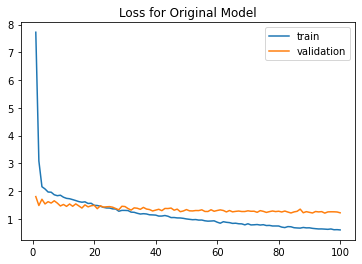

7/7 [==============================] - 1s 42ms/step
              precision    recall  f1-score   support

      arabic       0.00      0.00      0.00        20
     english       0.73      0.78      0.76       116
      french       0.08      0.08      0.08        13
    mandarin       0.43      0.23      0.30        13
     spanish       0.27      0.27      0.27        33

    accuracy                           0.53       195
   macro avg       0.30      0.27      0.28       195
weighted avg       0.52      0.53      0.52       195

[[ 0  5  5  1  9]
 [ 7 91  3  2 13]
 [ 4  7  1  0  1]
 [ 1  8  0  3  1]
 [ 7 13  3  1  9]]


In [16]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 100

checkpoint = ModelCheckpoint('weights/weights.hdf5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=[checkpoint], shuffle=True, validation_data=(X_val, y_val))
model.load_weights('weights/weights.hdf5')
model.evaluate(X_test, y_test)

# plot loss
plt.plot(range(1, epochs+1), history.history['loss'], label='train')
plt.plot(range(1, epochs+1), history.history['val_loss'], label='validation')
plt.title('Loss for Original Model')
plt.legend()
plt.show()

# test metrics and confidence matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_labels = np.argmax(y_test, axis=1)
print(classification_report(y_labels, y_pred, target_names=le.classes_.tolist()))
print(confusion_matrix(y_labels, y_pred))


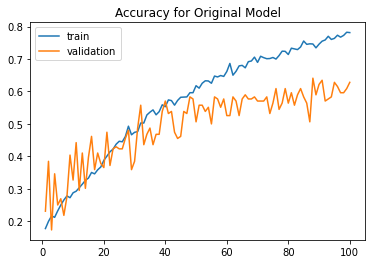

In [17]:
plt.plot(range(1, epochs+1), history.history['accuracy'], label='train')
plt.plot(range(1, epochs+1), history.history['val_accuracy'], label='validation')
plt.title('Accuracy for Original Model')
plt.legend()
plt.show()

# KMeans

100%|██████████| 8/8 [00:45<00:00,  5.69s/it]


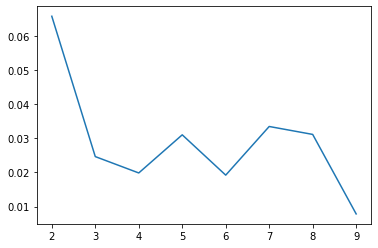

In [18]:
# get X_mfcc
X_mfcc = np.array([librosa.feature.mfcc(y=x, sr=16000, n_mfcc=N_MFCC) for x in tqdm(X)])
X_mfcc = X_mfcc.reshape(X_mfcc.shape[0], -1)

# kmeans
ks = range(2, 10)
silhouettes = []
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(X_mfcc)
    silhouette_avg = silhouette_score(X_mfcc, cluster_labels)
    silhouettes.append(silhouette_avg)
    
plt.plot(ks, silhouettes)
plt.show()
# 2 clusters is best

In [19]:
# divide into 2 clusters
kmeans = KMeans(n_clusters=2)
cluster_df = pd.DataFrame({'cluster label':kmeans.fit_predict(X_mfcc),
                        'language':y})
cluster_df.head()

,cluster label,language
38,1,arabic
39,0,arabic
40,0,arabic
41,0,arabic
42,1,arabic


In [20]:
cluster_df = pd.concat([cluster_df, pd.get_dummies(cluster_df['language'])], axis='columns')

In [21]:
cluster_df.corr()

,cluster label,arabic,english,french,mandarin,spanish
cluster label,1.000000,-0.163699,0.131877,0.010645,-0.039019,-0.019800
arabic,-0.163699,1.000000,-0.416377,-0.090244,-0.091766,-0.153311
english,0.131877,-0.416377,1.000000,-0.320128,-0.325528,-0.543850
french,0.010645,-0.090244,-0.320128,1.000000,-0.070554,-0.117872
mandarin,-0.039019,-0.091766,-0.325528,-0.070554,1.000000,-0.119860
spanish,-0.019800,-0.153311,-0.543850,-0.117872,-0.119860,1.000000


In [22]:
# split data by cluster
X0 = X[cluster_df['cluster label'] == 0]
X1 = X[cluster_df['cluster label'] == 1]
y0 = y[cluster_df['cluster label'] == 0]
y1 = y[cluster_df['cluster label'] == 1]
print(X0.shape, X1.shape)

(482, 263369) (489, 263369)


In [23]:
X0_train, X0_test, X0_val, y0_train, y0_test, y0_val = preproc(X0, y0, N_MFCC)
X1_train, X1_test, X1_val, y1_train, y1_test, y1_val = preproc(X1, y1, N_MFCC)

100%|██████████| 79/79 [00:02<00:00, 36.82it/s]


In [24]:
input_shape = X_train.shape[1:]
kernel_size=3

# define network
model = Sequential()
model.add(Conv2D(16, kernel_size=kernel_size, padding='same', input_shape=input_shape))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(32, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(128, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

Epoch 1/100
26/26 [==============================] - 5s 142ms/step - loss: 1.2265 - accuracy: 0.5706 - val_loss: 0.8391 - val_accuracy: 0.7403
Epoch 2/100
26/26 [==============================] - 4s 143ms/step - loss: 1.2229 - accuracy: 0.5632 - val_loss: 0.8474 - val_accuracy: 0.7403
Epoch 3/100
26/26 [==============================] - 4s 153ms/step - loss: 1.1916 - accuracy: 0.5779 - val_loss: 0.8622 - val_accuracy: 0.7662
Epoch 4/100
26/26 [==============================] - 4s 156ms/step - loss: 1.1754 - accuracy: 0.5644 - val_loss: 0.8692 - val_accuracy: 0.7662
Epoch 5/100
26/26 [==============================] - 4s 152ms/step - loss: 1.1602 - accuracy: 0.5632 - val_loss: 0.8699 - val_accuracy: 0.7532
Epoch 6/100
26/26 [==============================] - 4s 158ms/step - loss: 1.1728 - accuracy: 0.5632 - val_loss: 0.8768 - val_accuracy: 0.7532
Epoch 7/100
26/26 [==============================] - 4s 164ms/step - loss: 1.1549 - accuracy: 0.5509 - val_loss: 0.8819 - val_accuracy: 0.7403

Epoch 58/100
26/26 [==============================] - 5s 177ms/step - loss: 1.0709 - accuracy: 0.5865 - val_loss: 0.8774 - val_accuracy: 0.7403
Epoch 59/100
26/26 [==============================] - 4s 159ms/step - loss: 1.0349 - accuracy: 0.6294 - val_loss: 0.8725 - val_accuracy: 0.7532
Epoch 60/100
26/26 [==============================] - 4s 161ms/step - loss: 1.0181 - accuracy: 0.6172 - val_loss: 0.8696 - val_accuracy: 0.7532
Epoch 61/100
26/26 [==============================] - 4s 153ms/step - loss: 1.0003 - accuracy: 0.6307 - val_loss: 0.8713 - val_accuracy: 0.7403
Epoch 62/100
26/26 [==============================] - 4s 162ms/step - loss: 1.0251 - accuracy: 0.6160 - val_loss: 0.8762 - val_accuracy: 0.7403
Epoch 63/100
26/26 [==============================] - 4s 160ms/step - loss: 1.0469 - accuracy: 0.5816 - val_loss: 0.8772 - val_accuracy: 0.7532
Epoch 64/100
26/26 [==============================] - 4s 155ms/step - loss: 1.0078 - accuracy: 0.6393 - val_loss: 0.8780 - val_accuracy:

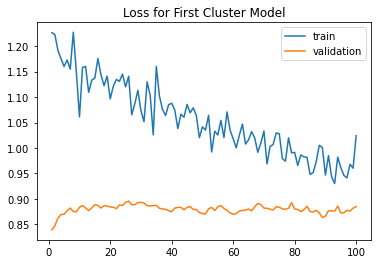

4/4 [==============================] - 0s 35ms/step
              precision    recall  f1-score   support

      arabic       0.75      0.80      0.77        15
     english       0.92      0.87      0.89        52
      french       0.60      0.50      0.55         6
    mandarin       1.00      0.57      0.73         7
     spanish       0.39      0.53      0.45        17

    accuracy                           0.75        97
   macro avg       0.73      0.65      0.68        97
weighted avg       0.79      0.75      0.76        97

[[12  0  1  0  2]
 [ 0 45  0  0  7]
 [ 1  0  3  0  2]
 [ 0  0  0  4  3]
 [ 3  4  1  0  9]]


In [25]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

# train on cluster0
model.load_weights('weights/weights.hdf5')  # load weights from original model
checkpoint = ModelCheckpoint('weights/weights0.hdf5', monitor='val_loss', save_best_only=True)
history = model.fit(X0_train, y0_train, epochs=epochs, callbacks=[checkpoint], shuffle=True, validation_data=(X0_val, y0_val))
model.load_weights('weights/weights0.hdf5')
model.evaluate(X0_test, y0_test)

# plot loss
plt.plot(range(1, epochs+1), history.history['loss'], label='train')
plt.plot(range(1, epochs+1), history.history['val_loss'], label='validation')
plt.title('Loss for First Cluster Model')
plt.legend()
plt.show()

# test metrics and confidence matrix
y_pred = np.argmax(model.predict(X0_test), axis=1)
y_labels = np.argmax(y0_test, axis=1)
print(classification_report(y_labels, y_pred, target_names=le.classes_.tolist()))
print(confusion_matrix(y_labels, y_pred))

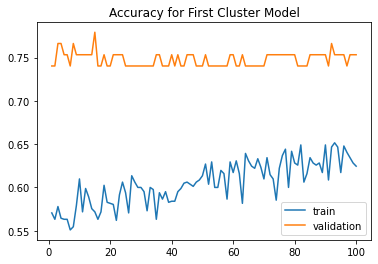

In [26]:
plt.plot(range(1, epochs+1), history.history['accuracy'], label='train')
plt.plot(range(1, epochs+1), history.history['val_accuracy'], label='validation')
plt.title('Accuracy for First Cluster Model')
plt.legend()
plt.show()

In [27]:
input_shape = X_train.shape[1:]
kernel_size=3

# define network
model = Sequential()
model.add(Conv2D(16, kernel_size=kernel_size, padding='same', input_shape=input_shape))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(32, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Conv2D(128, kernel_size=kernel_size, padding='same'))
model.add(LeakyReLU())
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 20, 515, 16)       160       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 20, 515, 16)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 257, 16)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 257, 32)       4640      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 10, 257, 32)       0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 128, 32)       0         
 2D)                                                  

Epoch 1/100
33/33 [==============================] - 7s 169ms/step - loss: 1.5910 - accuracy: 0.4058 - val_loss: 0.8460 - val_accuracy: 0.7342
Epoch 2/100
33/33 [==============================] - 5s 153ms/step - loss: 1.5124 - accuracy: 0.4437 - val_loss: 0.9180 - val_accuracy: 0.6709
Epoch 3/100
33/33 [==============================] - 5s 162ms/step - loss: 1.4809 - accuracy: 0.4252 - val_loss: 0.9455 - val_accuracy: 0.6582
Epoch 4/100
33/33 [==============================] - 5s 153ms/step - loss: 1.4578 - accuracy: 0.4291 - val_loss: 0.9907 - val_accuracy: 0.6329
Epoch 5/100
33/33 [==============================] - 5s 162ms/step - loss: 1.4117 - accuracy: 0.4447 - val_loss: 0.9868 - val_accuracy: 0.6329
Epoch 6/100
33/33 [==============================] - 6s 176ms/step - loss: 1.4156 - accuracy: 0.4427 - val_loss: 0.9695 - val_accuracy: 0.6456
Epoch 7/100
33/33 [==============================] - 5s 166ms/step - loss: 1.3849 - accuracy: 0.4699 - val_loss: 0.9788 - val_accuracy: 0.6456

Epoch 58/100
33/33 [==============================] - 4s 122ms/step - loss: 1.1623 - accuracy: 0.5485 - val_loss: 0.9963 - val_accuracy: 0.6456
Epoch 59/100
33/33 [==============================] - 4s 125ms/step - loss: 1.2081 - accuracy: 0.5262 - val_loss: 0.9951 - val_accuracy: 0.6456
Epoch 60/100
33/33 [==============================] - 4s 128ms/step - loss: 1.2107 - accuracy: 0.5136 - val_loss: 0.9933 - val_accuracy: 0.6456
Epoch 61/100
33/33 [==============================] - 4s 126ms/step - loss: 1.1874 - accuracy: 0.5272 - val_loss: 0.9824 - val_accuracy: 0.6582
Epoch 62/100
33/33 [==============================] - 4s 132ms/step - loss: 1.2152 - accuracy: 0.5223 - val_loss: 0.9971 - val_accuracy: 0.6456
Epoch 63/100
33/33 [==============================] - 4s 130ms/step - loss: 1.1945 - accuracy: 0.5350 - val_loss: 0.9962 - val_accuracy: 0.6329
Epoch 64/100
33/33 [==============================] - 4s 128ms/step - loss: 1.1789 - accuracy: 0.5388 - val_loss: 1.0111 - val_accuracy:

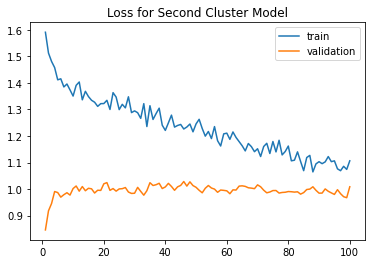

4/4 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

      arabic       0.50      0.20      0.29         5
     english       0.87      0.85      0.86        65
      french       0.80      0.57      0.67         7
    mandarin       0.67      0.80      0.73         5
     spanish       0.59      0.81      0.68        16

    accuracy                           0.79        98
   macro avg       0.69      0.65      0.64        98
weighted avg       0.79      0.79      0.78        98

[[ 1  3  1  0  0]
 [ 0 55  0  1  9]
 [ 0  3  4  0  0]
 [ 0  1  0  4  0]
 [ 1  1  0  1 13]]


In [28]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

# train on cluster1
model.load_weights('weights/weights.hdf5')  # load weights from original model
checkpoint = ModelCheckpoint('weights/weights1.hdf5', monitor='val_loss', save_best_only=True)
history = model.fit(X1_train, y1_train, epochs=epochs, callbacks=[checkpoint], shuffle=True, validation_data=(X1_val, y1_val))
model.load_weights('weights/weights1.hdf5')
model.evaluate(X1_test, y1_test)

# plot loss
plt.plot(range(1, epochs+1), history.history['loss'], label='train')
plt.plot(range(1, epochs+1), history.history['val_loss'], label='validation')
plt.title('Loss for Second Cluster Model')
plt.legend()
plt.show()

# test metrics and confidence matrix
y_pred = np.argmax(model.predict(X1_test), axis=1)
y_labels = np.argmax(y1_test, axis=1)
print(classification_report(y_labels, y_pred, target_names=le.classes_.tolist()))
print(confusion_matrix(y_labels, y_pred))

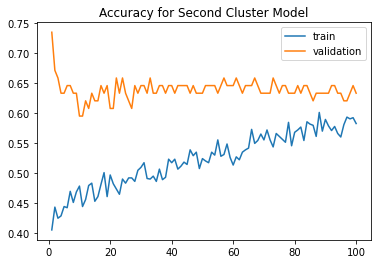

In [29]:
plt.plot(range(1, epochs+1), history.history['accuracy'], label='train')
plt.plot(range(1, epochs+1), history.history['val_accuracy'], label='validation')
plt.title('Accuracy for Second Cluster Model')
plt.legend()
plt.show()

In [30]:
print(X0.shape)
print(X1.shape)

(482, 263369)
(489, 263369)
